**Reference**

Github:https://github.com/bwilder95/Test-Area/blob/master/COLAB/GPP_Example.ipynb

StackOverflow: https://stackoverflow.com/questions/20965046/cumulative-sum-and-percentage-on-column

## Instalacion de librerias

In [276]:
import pandas as pd
import ee
ee.Initialize()

## Crear una coleccion

In [277]:
dataset = ee.ImageCollection('MODIS/006/MOD17A2H')

# Initial date of interest (inclusive).
i_date = '2020-01-01'

# Final date of interest (exclusive).
f_date = '2020-12-31'

# Selection of appropriate bands and dates.
GPP = dataset.select('Gpp').filterDate(i_date, f_date)

## Crear un punto de analisis

In [278]:
# Crear una geometria de tipo punto

p_lon = -100.7917
p_lat = 21.0721
test_point = ee.Geometry.Point(p_lon, p_lat)

In [279]:
scale = 250  # scale in meters

# Calculate and print the mean value of the collection at the point.
GPP_test_point = GPP.mean().sample(test_point, scale).first().get('Gpp').getInfo()
print('GPP Value:', GPP_test_point, 'kg*C/m^2')

GPP Value: 101.56521739130434 kg*C/m^2


In [280]:
# Create function that takes median of single band (gpp in this case) for ca
def reduce(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=test_point
                               ,scale=250).get('Gpp')
    return img.set('date', img.date().format()).set('mean',mean)

In [281]:
# Reduce images
reduce_dataset = GPP.map(reduce)

In [282]:
# Save to pandas df
reduce_list = reduce_dataset.reduceColumns(ee.Reducer.toList(2), ['date','mean',]).values().get(0)
df = pd.DataFrame(reduce_list.getInfo(), columns=['Date','Mean GPP (kg*C/m^2/8-day)'])
df.head()

,Date,Mean GPP (kg*C/m^2/8-day)
0,2020-01-01T00:00:00,55
1,2020-01-09T00:00:00,54
2,2020-01-17T00:00:00,57
3,2020-01-25T00:00:00,65
4,2020-02-02T00:00:00,67


## Generacion de los valores acumulativos

In [283]:
df['cum_sum'] = df['Mean GPP (kg*C/m^2/8-day)'].cumsum()
df.head()

,Date,Mean GPP (kg*C/m^2/8-day),cum_sum
0,2020-01-01T00:00:00,55,55
1,2020-01-09T00:00:00,54,109
2,2020-01-17T00:00:00,57,166
3,2020-01-25T00:00:00,65,231
4,2020-02-02T00:00:00,67,298


In [284]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df.head()

,Mean GPP (kg*C/m^2/8-day),cum_sum
Date,,
2020-01-01,55,55
2020-01-09,54,109
2020-01-17,57,166
2020-01-25,65,231
2020-02-02,67,298


## Generar un grafico

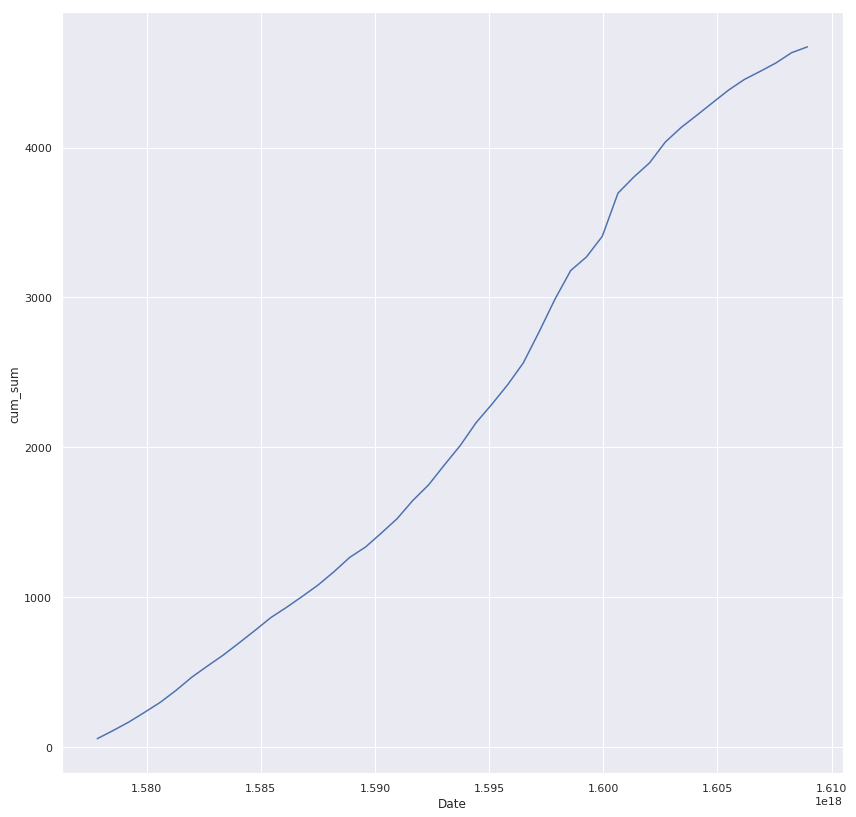

In [285]:
import seaborn as sns

sns.set(rc={'figure.figsize':(14,14)})
sns.lineplot(x='Date',y='cum_sum',data=df,legend='full', palette='winter')